# GBSV Minichallenge 1 Notebook 1

Dieses Notbook enthält die Abgaben für die Tage 1 - 3 für die GBSV Minichallenge 1. Der Code sowie die Daten sind in einem GitHub Repository verfügbar und unter diesem Link zu finden: [GitHub Repository](https://github.com/adrianmeier2002/gbsv_minichallenges).

In [13]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate, resample_poly
import matplotlib.dates as mdates

# Day 1
## Motivation und Hintergrund
Ich habe für die GBSV Minichallenge Kanada als Land gewählt, da Teile meiner Familie (Onkel und Cousin) in Kanada, genauer in Montreal, leben. Ich war selber schon zwei Mal in Kanada und habe gerade Montreal als sehr schöne Stadt in Erinnerung. In der Stadt ist neben dem namensgebenden Hügel, dem Mont Royal, auch der St.-Lawrence Strom allgegenwärtig im Stadtbild. Um ihn herum hat sich die Stadt Montreal entwickelt. Da ich mich auch für Schifffahrt interessiere, war der Fluss für mich immer ein spannendes Thema welches mir direkt in den Sinn kam. Es gibt entlang des Flusses viele Häfen und Messstationen, welche ihre Daten öffentlich zur Verfügung stellen.

![St.-Lawrence Strom in Montreal](images/lorenz_montreal.jpg)  
*St.-Lawrence Strom in Montreal*

## Nyquist-Shannon Sampling Theorem
### Problemstellung
Der Sankt Lorenz Strom wird von den grossen Seen gespeist und fliesst in den Atlantik. In Kanada spielt der St.-Lawrence-Strom eine entscheidende Rolle für Schifffahrt, Energie und Ökosysteme. Für Hafenbehörden ist es wichtig, den Wasserstand kontinuierlich zu überwachen, da er durch Gezeiten, saisonale Effekte und Wetterbedingungen schwankt. Wir haben stündliche Daten des Wasserstands von einer Messstation in Montreal, welche wir analysieren wollen. Dadurch sollen die Wasserstände besser vorhergesagt werden können und so ein auf Grund laufen der Schiffe verhindert werden.

![Grosse Seen und St.-Lawrence Strom](images/lorenz_strom.jpg)  
*Grosse Seen und der St.-Lawrence Strom*

Quelle der Daten: https://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/inventory-inventaire/sd-ds-eng.asp?no=15540&user=isdm-gdsi&region=MEDS

In [2]:
# Einlesen der CSV-Datei
water_raw = pd.read_csv(
    "data/st_lawrence_water.csv",
    skiprows=8, 
    usecols=[0, 1],                # nur die ersten beiden Spalten laden
    names=["Observed_date", "Sealevel"],    # Spaltennamen setzen
    parse_dates=["Observed_date"],      # Datum parsen
    encoding="latin1"
)

print(water_raw.head())

        Observed_date  Sealevel
0 2015-01-01 00:00:00      0.32
1 2015-01-01 01:00:00      0.32
2 2015-01-01 02:00:00      0.33
3 2015-01-01 03:00:00      0.33
4 2015-01-01 04:00:00      0.33


Wir haben ein stündlich gemessenes Signal des Wasserstands des St.-Lawrence-Stroms von einer Messstation in Montreal. Das Signal enthält eine Periodische Komponente, welche durch die Jahreszeit verursacht wird. Zudem können auch die Gezeiten den Wasserstand beeinflussen, diese sind zwar abgeschwächt, aber dennoch möglicherweise vorhanden.

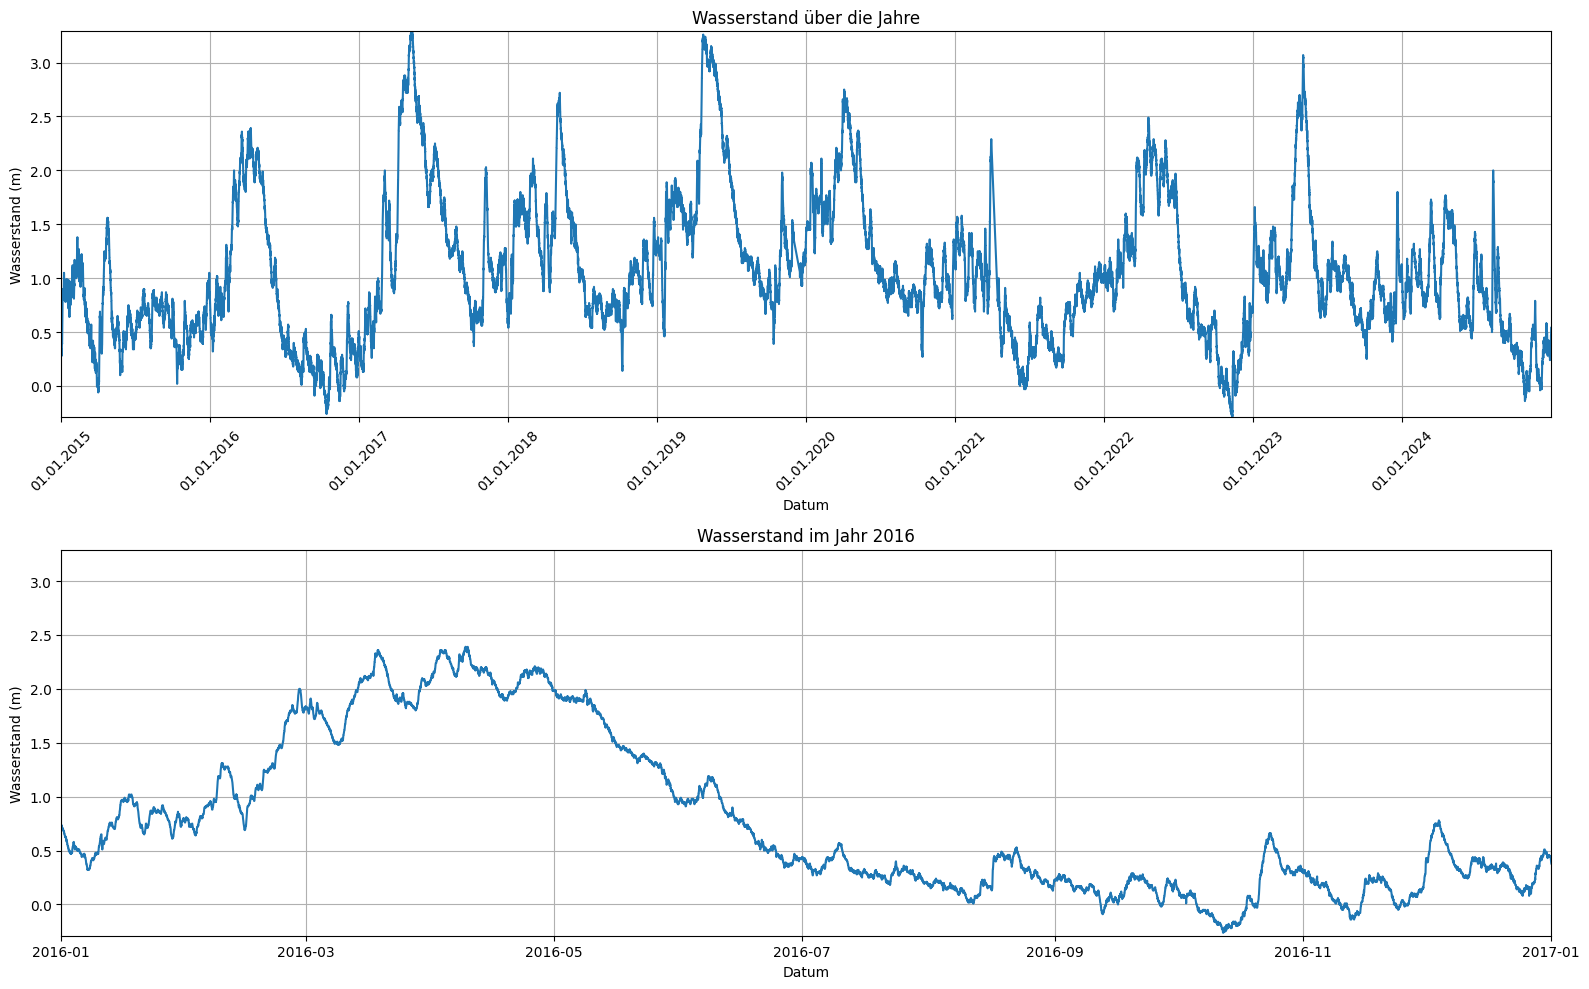

In [15]:
# Plotten der Daten einmal über die ganzen Jahre und für ein Jahr
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(water_raw["Observed_date"], water_raw["Sealevel"])
plt.title("Wasserstand über die Jahre")
plt.xlabel("Datum")
plt.ylabel("Wasserstand (m)")
plt.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m.%Y"))
plt.xticks(rotation=45)
plt.xlim([water_raw["Observed_date"].min(), water_raw["Observed_date"].max()])
plt.ylim([water_raw["Sealevel"].min(), water_raw["Sealevel"].max()])
plt.subplot(2, 1, 2)
plt.plot(water_raw["Observed_date"], water_raw["Sealevel"])
plt.title("Wasserstand im Jahr 2016")
plt.xlabel("Datum")
plt.ylabel("Wasserstand (m)")
plt.grid()
plt.xlim([pd.Timestamp("2016-01-01"), pd.Timestamp("2017-01-01")])
plt.ylim([water_raw["Sealevel"].min(), water_raw["Sealevel"].max()])
plt.tight_layout()
plt.show()

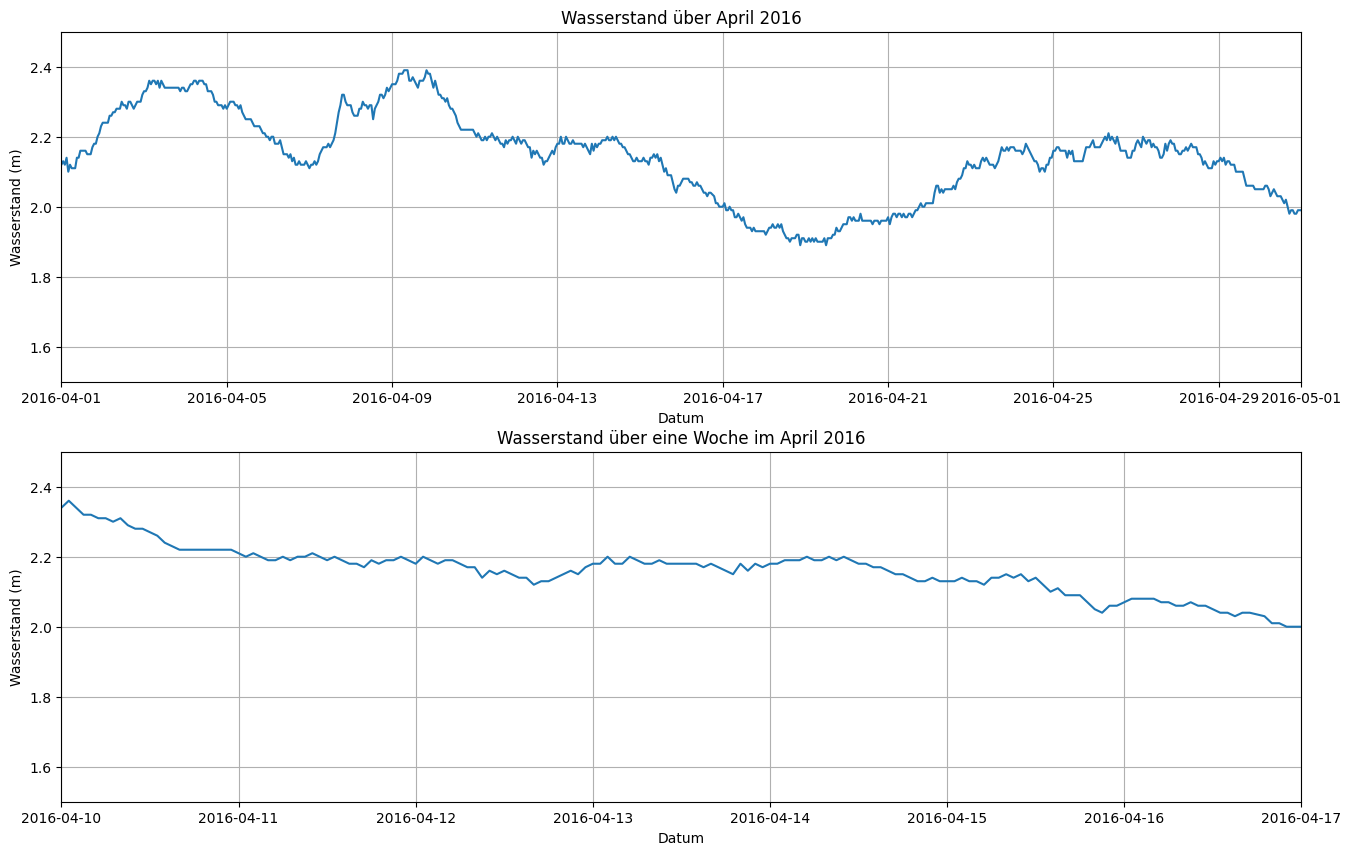

In [4]:
# # Plotten der Daten einmal über einen Monat und eine Woche
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(water_raw["Observed_date"], water_raw["Sealevel"])
plt.title("Wasserstand über April 2016")
plt.xlabel("Datum")
plt.ylabel("Wasserstand (m)")
plt.grid()
plt.xlim([pd.Timestamp("2016-04-01"), pd.Timestamp("2016-05-01")])
plt.ylim([1.5, 2.5])
plt.subplot(2, 1, 2)
plt.plot(water_raw["Observed_date"], water_raw["Sealevel"])
plt.title("Wasserstand über eine Woche im April 2016")
plt.xlabel("Datum")
plt.ylabel("Wasserstand (m)")
plt.grid()
plt.xlim([pd.Timestamp("2016-04-10"), pd.Timestamp("2016-04-17")])
plt.ylim([1.5, 2.5])
plt.show()


### Niquist-Rate und Niquist-Frequenz
Die Maximal relevante Frequenz, welche wir Beobachten wollen, ist die Frequenz der Gezeiten. Diese beträgt ca. 2 Zyklen pro Tag (2 mal Hochwasser und 2 mal Niedrigwasser pro Tag). <span style="background-color:yellow">Daraus ergibt sich eine maximale Frequenz von 2/24 cycles/hour = 1/12 cycles/hour = 0.0833 cycles/hour, was in Hertz etwa $2.31 * 10^{-5}$ wären.
Gemäss dem Nyquist-Shannon Sampling Theorem muss die Rate mindestens doppelt so hoch sein, wie die maximale Frequenz, also mindestens 0.1666 cycles/hour ($4.62 * 10^{-5}$ Hz). Dies entspricht einer Abtastung alle 6 Stunden, was in unserem Fall mit einer stündlichen Erhebung der Daten gut erfüllt ist.

Zusammendassend bekommen wir eine **Nyquist-Rate von 0.1666 cycles/hour** und eine **Nyquist-Frequenz von 0.0833 cycles/hour**. </span>

### Warum ist das wichtig?  
Wenn wir die Daten zu selten aufnehmen, können wir die hohen Frequenzen nicht mehr korrekt abbilden. Dies führt zu einem Phänomen, welches Aliasing genannt wird. Dabei werden hohe Frequenzen als tiefere Frequenzen interpretiert, was zu einer Verzerrung des Signals führt. In unserem Fall könnte dies bedeuten, dass änderungen im Wasserstand, welche durch die Gezeiten verursacht werden, nicht korrekt erkannt werden. Beispielsweise könnte die Messung täglich nur während der Flutzeit erfolgen. Dadurch würden die Gezeiten nicht erkannt werden und es könnte zu falschen Vorhersagen des Wasserstands kommen, was für die Schifffahrt gefährlich sein kann. Mit der stündlichen Messung können wir jedoch die auswirkungen der Gezeiten und andere schnelle Änderungen im Wasserstand gut erfassen.

## Day 2
### Nyquist-Demonstration mit St.-Lawrence Wasserstandsdaten
Für das gegebene stündliche Wasserstandssignal soll die Nyquist-Rate/Frequenz gezeigt werden, die höchste relevante Frequenz per FFT geschätzt werden und Aliasing bei zu grobem Sampling gezeigt werden.

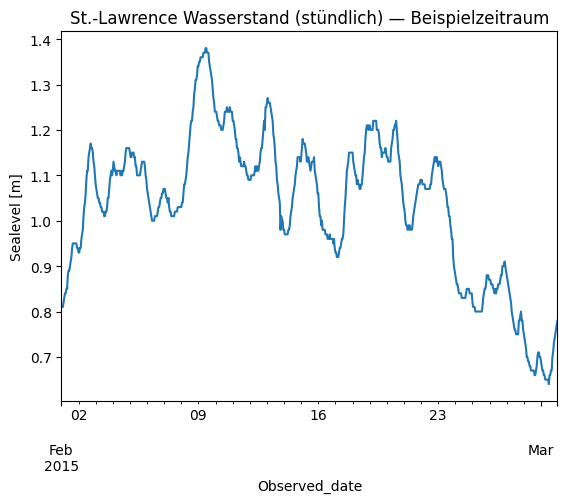

In [5]:
# Index setzen
water = water_raw.copy()
water = water.set_index("Observed_date")
water = water.asfreq("h")  # erzwinge stündlichen Zeitindex
water["Sealevel"] = water["Sealevel"].interpolate(limit=6)

# Zeitraum auswählen (Januar 2015)
sig = water.loc["2015-02-01":"2015-03-01", "Sealevel"].dropna()

# Plot zur Kontrolle
sig.plot(title="St.-Lawrence Wasserstand (stündlich) — Beispielzeitraum")
plt.ylabel("Sealevel [m]")
plt.show()

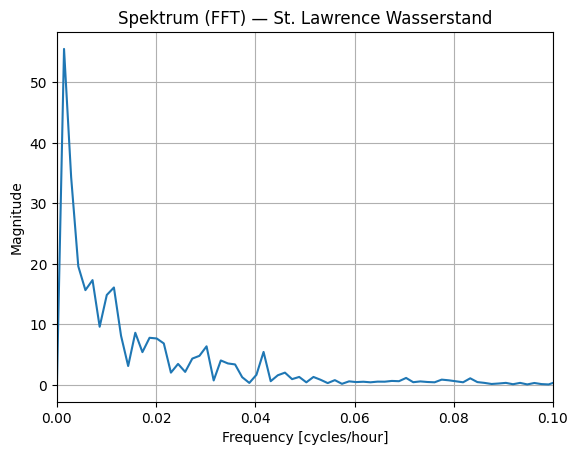

Geschätztes f_max = 0.0417 cycles/hour
Nyquist-Rate = 0.0833 samples/hour
Maximales Abtastintervall = 720.0 Minuten


In [6]:
x = sig.values
N = len(x)
fs = 1.0  # 1 sample per hour
Xf = np.fft.rfft(x - np.mean(x))
freqs = np.fft.rfftfreq(N, d=1.0/fs)  # cycles per hour
mag = np.abs(Xf)

plt.plot(freqs, mag)
plt.xlim(0, 0.1)   # Frequenzen bis 0.1 cycle/hour anzeigen
plt.xlabel("Frequency [cycles/hour]")
plt.ylabel("Magnitude")
plt.title("Spektrum (FFT) — St. Lawrence Wasserstand")
plt.grid(True)
plt.show()

# f_max bestimmen (z. B. mit 5%-Schwelle)
threshold = 0.05 * np.max(mag)
significant = freqs[mag > threshold]
f_max = significant.max() if len(significant) > 0 else 0.0

nyquist_freq = f_max
nyquist_rate = 2.0 * nyquist_freq
max_interval_hours = 1.0 / nyquist_rate if nyquist_rate > 0 else np.inf

print(f"Geschätztes f_max = {f_max:.4f} cycles/hour")
print(f"Nyquist-Rate = {nyquist_rate:.4f} samples/hour")
print(f"Maximales Abtastintervall = {max_interval_hours*60:.1f} Minuten")

Man sieht, dass das Signal für die Stüdliche Berechnung sehr konstant ist und deshalb die Frequenzen sehr tief sind. Die höchste relevante Frequenz ist bei ca. 0.04 cycles/hour, was einer Periode von ca. 25 Stunden entspricht. Es zeigt auf, dass keine grossen Änderungen im Wasserstand durch die Gezeiten auftreten.

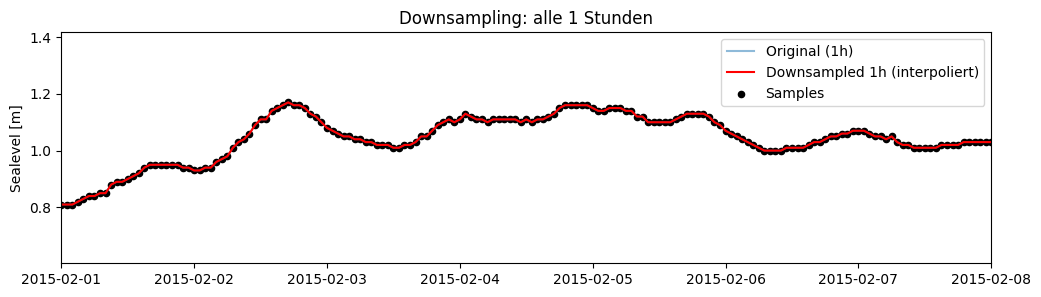

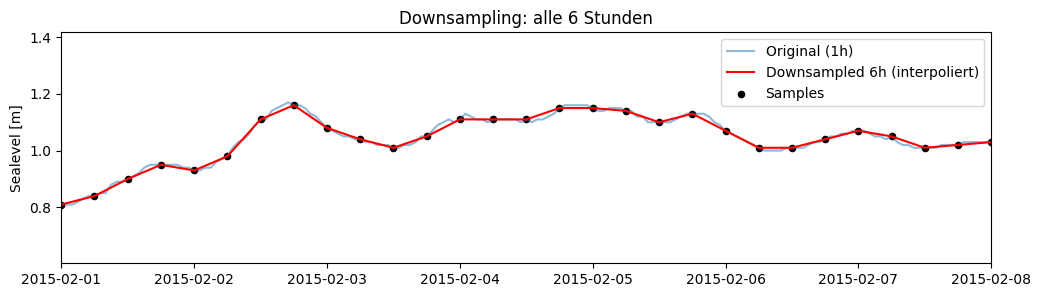

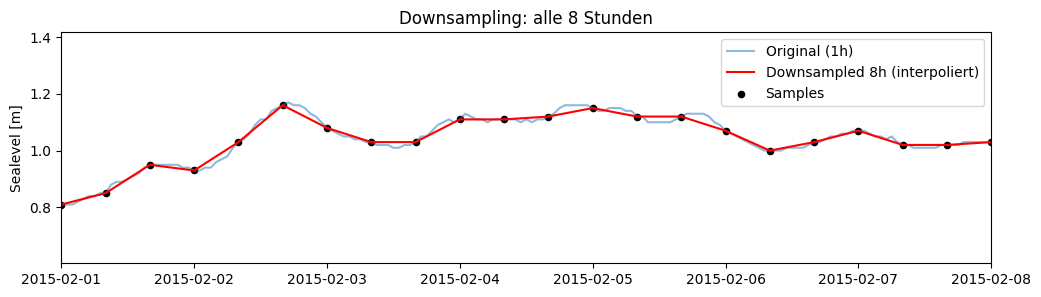

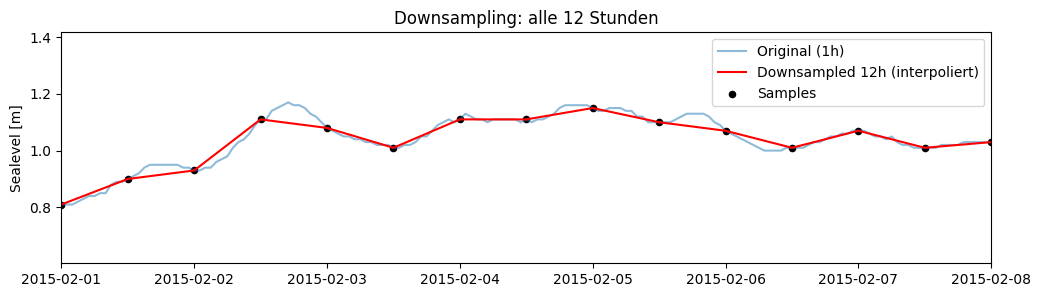

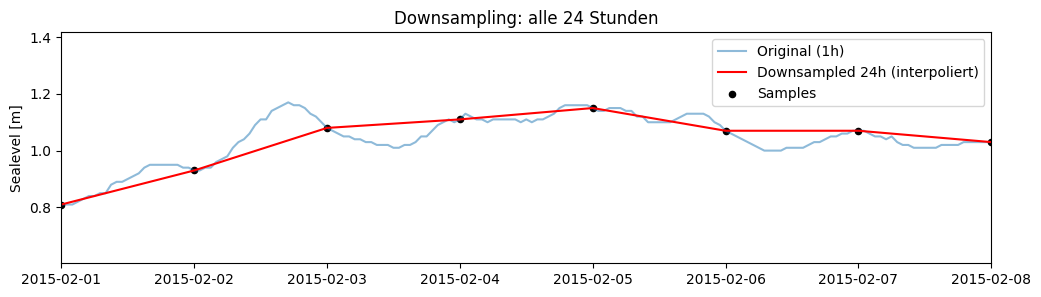

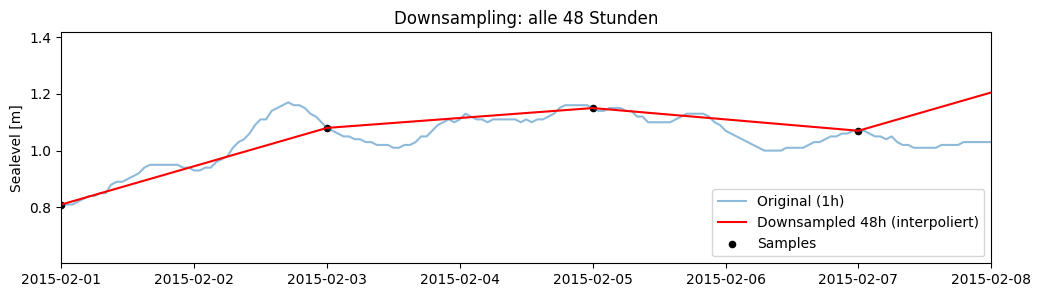

In [7]:
def downsample_naive(series, ds_hours):
    step = int(ds_hours)
    return series.iloc[::step]

def plot_downsample(original, ds_hours):
    ds = downsample_naive(original, ds_hours)
    ds_interp = ds.reindex(original.index).interpolate(method='time')
    plt.figure(figsize=(12,3))
    plt.plot(original.index, original.values, label="Original (1h)", alpha=0.5)
    plt.plot(ds_interp.index, ds_interp.values, label=f"Downsampled {ds_hours}h (interpoliert)", color='r')
    plt.scatter(ds.index, ds.values, color='k', s=20, label="Samples")
    plt.xlim(original.index[0], original.index[min(24*7, len(original)-1)])  # 1 Woche zeigen
    plt.legend()
    plt.title(f"Downsampling: alle {ds_hours} Stunden")
    plt.ylabel("Sealevel [m]")
    plt.show()

for ds in [1, 6, 8, 12, 24, 48]:
    plot_downsample(sig, ds)

Im Downsampling sieht man klar, dass die Signale ungenauer werden, wenn die Daten zu grob abgetastet werden. Da es aber keine klaren unterschiede durch die Gezeiten gibt, ist das Signal auch bei grösseren Downsampling Faktoren noch relativ gut erkennbar (Bis ca. 12 Stunden).

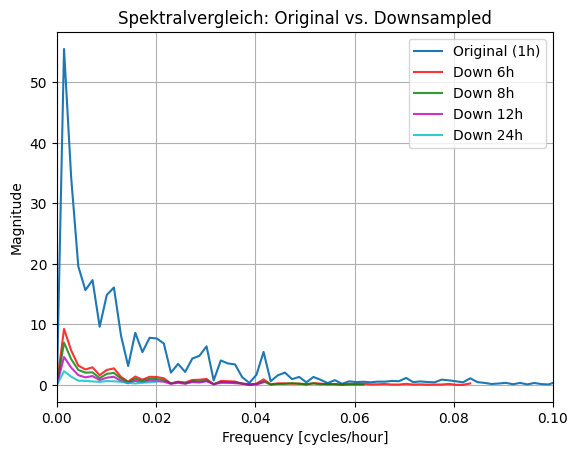

In [8]:
Xf_orig = np.fft.rfft(sig.values - np.mean(sig.values))
freqs_orig = np.fft.rfftfreq(len(sig), d=1.0) * 1.0   # cycles/hour
mag_orig = np.abs(Xf_orig)

plt.plot(freqs_orig, mag_orig, label="Original (1h)")
plt.xlim(0, 0.1)
plt.xlabel("Frequency [cycles/hour]")
plt.ylabel("Magnitude")
plt.title("Spektralvergleich: Original vs. Downsampled")
plt.grid(True)

for ds, col in zip([6, 8, 12, 24], ['r','g','m','c']):
    ds_series = downsample_naive(sig, ds)
    Xf_ds = np.fft.rfft(ds_series.values - np.mean(ds_series.values))
    freqs_ds = np.fft.rfftfreq(len(ds_series), d=1.0) * (1.0/ds)  # cycles/hour
    mag_ds = np.abs(Xf_ds)
    plt.plot(freqs_ds, mag_ds, label=f"Down {ds}h", alpha=0.8, color=col)

plt.legend()
plt.show()

Da die Gezeiten im St.-Lawrence Strom nur eine geringe Rolle spielen, will ich noch die Saisonalen Effekte anschauen. Dazu wird das Signal über mehrere Jahre geplottet, um mögliche Trends und Muster zu identifizieren.

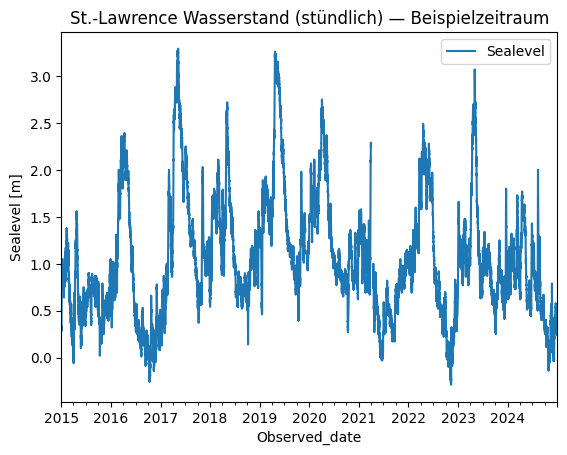

In [ ]:
# Index setzen
water_years = water_raw.copy()
water_years = water_years.set_index("Observed_date")
water_years = water_years.asfreq("h")  # erzwinge stündlichen Zeitindex
water_years["Sealevel"] = water_years["Sealevel"].interpolate(limit=6)

# Zeitraum auswählen (Januar 2015)
sig_years = water_years

# Plot zur Kontrolle
sig_years.plot(title="St.-Lawrence Wasserstand (stündlich) — Beispielzeitraum")
plt.ylabel("Sealevel [m]")
plt.show()

<span style="background-color:yellow">
Um eine Saisonalität in den Jahren zu erkennen, braucht man nach dem Nyquist-Shannon Sampling Theorem eine Abtastrate, welche mindestens doppelt so hoch ist, wie die maximale Frequenz. Die maximale Frequenz ist in diesem Fall 1 Zyklus pro Jahr (1/12 cycles/month = 0.0833 cycles/month). Daraus ergibt sich eine Nyquist-Rate von 2/12 cycles/month = 0.1666 cycles/month. Dies entspricht einer Abtastung alle 6 Monate. Um die saisonalen Schwankungen gut zu erfassen, sollten man also mindestens alle 6 Monate Daten aufnehmen. Um den Datensatz zu vereinfachen und die vielen kleinen täglichen Schwankungen zu glätten, werde ich die Daten auf einen Downsampling Faktor von 1 Punkt pro Monat reduzieren bevor ich die FFT durchführe.
</span>

<Figure size 1200x400 with 0 Axes>

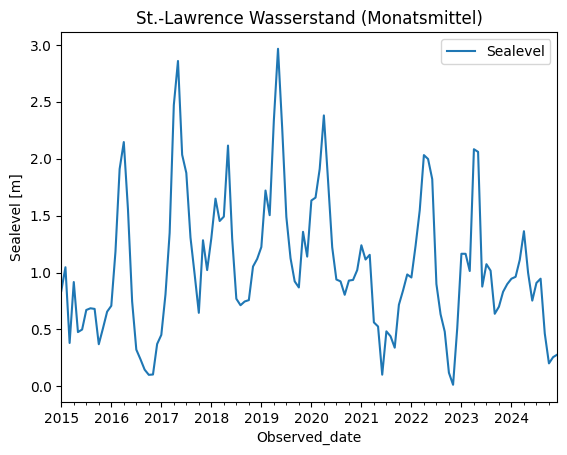

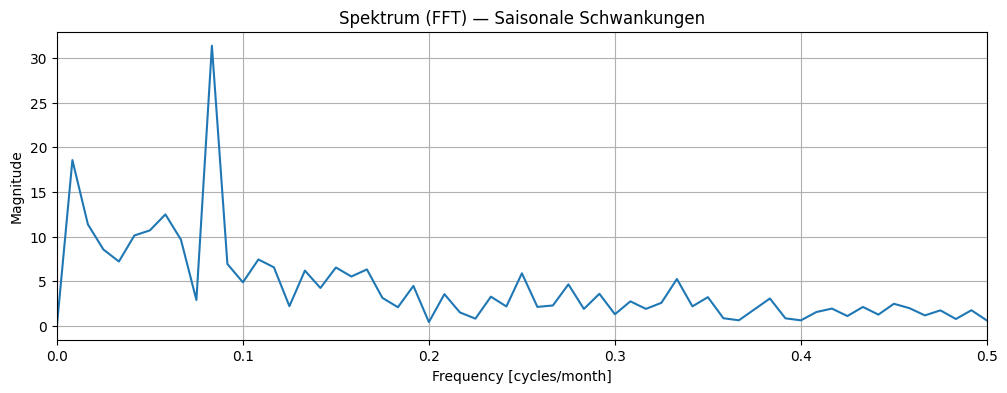

Geschätzte f_max (saisonal) = 0.35000 cycles/month
Nyquist-Rate = 0.70000 samples/month
Maximales Abtastintervall = 1.4 Monate
Höchste Magnitude bei 0.08333 cycles/month


In [10]:
sig_monthly = sig_years.resample("ME").mean().dropna()

plt.figure(figsize=(12,4))
sig_monthly.plot()
plt.title("St.-Lawrence Wasserstand (Monatsmittel)")
plt.ylabel("Sealevel [m]")
plt.show()

x = sig_monthly.values.flatten()   # statt nur .values
N = len(x)
fs = 1.0  # 1 sample pro Monat

Xf = np.fft.rfft(x - np.mean(x))
freqs = np.fft.rfftfreq(N, d=1.0/fs)
mag = np.abs(Xf)

plt.figure(figsize=(12,4))
plt.plot(freqs, mag)
plt.xlim(0, 0.5)
plt.xlabel("Frequency [cycles/month]")
plt.ylabel("Magnitude")
plt.title("Spektrum (FFT) — Saisonale Schwankungen")
plt.grid(True)
plt.show()

# wichtigste Frequenz finden
threshold = 0.1 * np.max(mag)
significant = freqs[mag > threshold]
f_max = significant.max() if len(significant) > 0 else 0.0

# Nyquist für saisonale Effekte
nyquist_freq = f_max
nyquist_rate = 2.0 * nyquist_freq
max_interval_days = 1.0 / nyquist_rate if nyquist_rate > 0 else np.inf

print(f"Geschätzte f_max (saisonal) = {f_max:.5f} cycles/month")
print(f"Nyquist-Rate = {nyquist_rate:.5f} samples/month")
print(f"Maximales Abtastintervall = {max_interval_days:.1f} Monate")
print(f"Höchste Magnitude bei {significant[np.argmax(mag[mag > threshold])]:.5f} cycles/month")

Man sieht einen klaren saisonalen Trend, dieser wird mit der Höchsten Magnitude bei ca. 0.08 cycles/month (1 Zyklus pro Jahr) in der FFT bestätigt. Es gibt zudem viele kleine Frequenzen welche wahrscheinlich durch Wettereffekte verursacht werden.

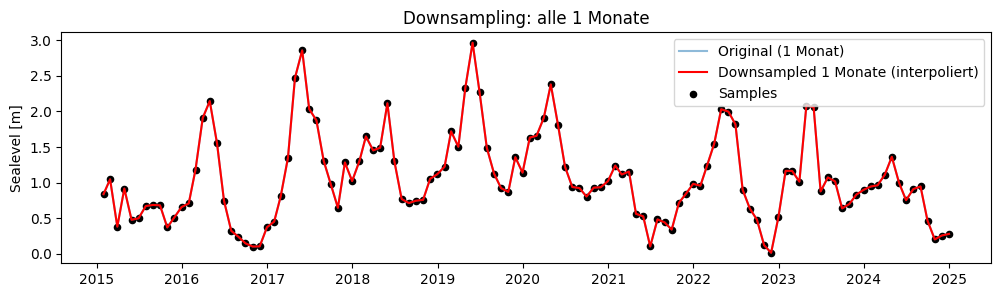

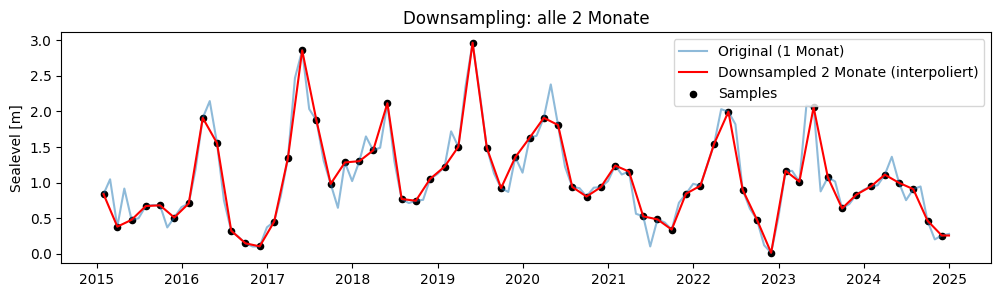

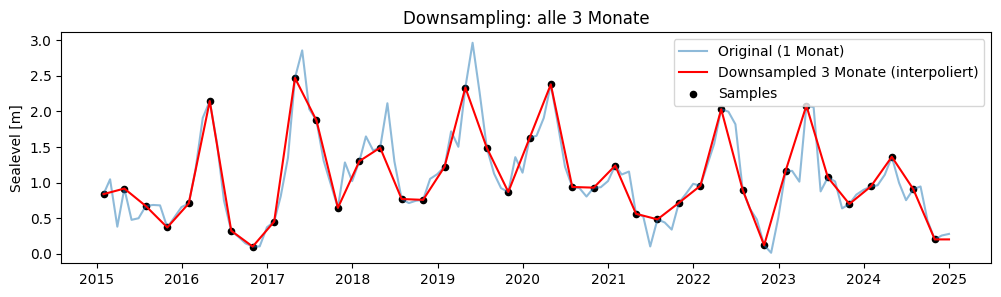

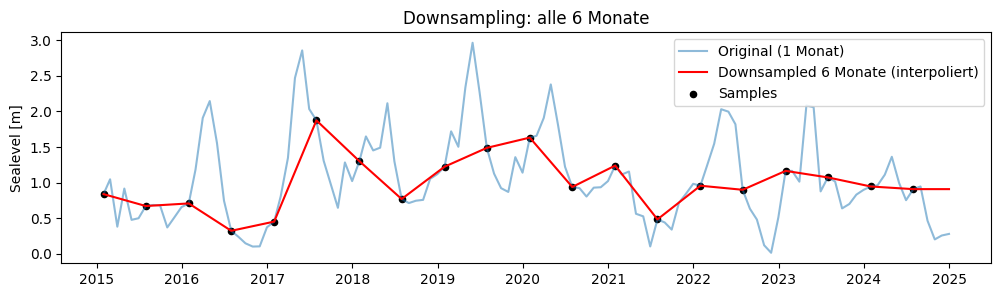

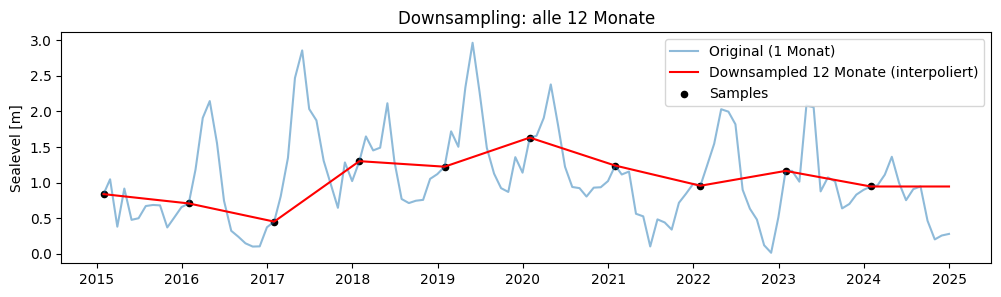

In [11]:
def downsample_naive(series, step_months):
    """Nimmt nur jedes step_months-te Sample (Monatsraster)."""
    step = int(step_months)
    return series.iloc[::step]

def plot_downsample(original, step_months):
    ds = downsample_naive(original, step_months)
    ds_interp = ds.reindex(original.index).interpolate(method='time')
    plt.figure(figsize=(12,3))
    plt.plot(original.index, original.values, label="Original (1 Monat)", alpha=0.5)
    plt.plot(ds_interp.index, ds_interp.values, 
             label=f"Downsampled {step_months} Monate (interpoliert)", color='r')
    plt.scatter(ds.index, ds.values, color='k', s=20, label="Samples")
    plt.legend()
    plt.title(f"Downsampling: alle {step_months} Monate")
    plt.ylabel("Sealevel [m]")
    plt.show()

# Beispiel: 1, 2, 3, 6, 12 Monate Abtastung
for step in [1, 2, 3, 6, 12]:
    plot_downsample(sig_monthly, step)

Hier sieht man nun ganz klar, dass bei einem zu hohen Downsampling Faktor (z.B. 1 Punkt pro 12 Monate) die saisonalen Schwankungen nicht mehr erkannt werden können. Bei einem Downsampling Faktor von 1 Punkt pro 3 Monate sind die saisonalen Schwankungen noch gut erkennbar.

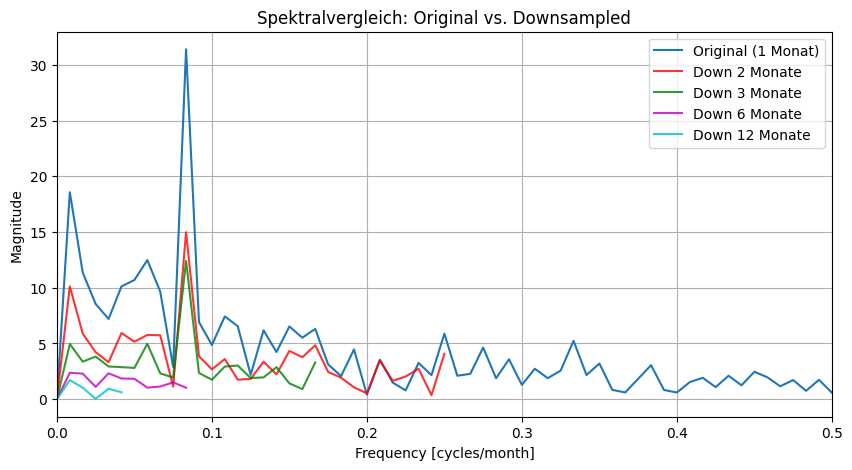

In [12]:
# --- Spektralvergleich ---
x = sig_monthly.values.flatten()
Xf_orig = np.fft.rfft(x - np.mean(x))
freqs_orig = np.fft.rfftfreq(len(x), d=1.0)   # cycles/month
mag_orig = np.abs(Xf_orig)

plt.figure(figsize=(10,5))
plt.plot(freqs_orig, mag_orig, label="Original (1 Monat)")
plt.xlim(0, 0.5)  # Nyquist bei 0.5 cycles/month
plt.xlabel("Frequency [cycles/month]")
plt.ylabel("Magnitude")
plt.title("Spektralvergleich: Original vs. Downsampled")
plt.grid(True)

for step, col in zip([2, 3, 6, 12], ['r','g','m','c']):
    ds_series = downsample_naive(sig_monthly, step)
    x_ds = ds_series.values.flatten()
    Xf_ds = np.fft.rfft(x_ds - np.mean(x_ds))
    # Samplingabstand = step Monate
    freqs_ds = np.fft.rfftfreq(len(x_ds), d=step)  # cycles/month
    mag_ds = np.abs(Xf_ds)
    plt.plot(freqs_ds, mag_ds, label=f"Down {step} Monate", alpha=0.8, color=col)

plt.legend()
plt.show()

Im Spektralvergleich wird noch einmal deutlich, dass die saisonalen Schwankungen bei einem Downsampling Faktor von einem Punkt pro 6 oder 12 Monate nicht mehr erkannt werden können.

# Day 3
## Fazit
In der Analyse habe ich gesehen, dass die stündliche Abtastung der Wasserstandsdaten des St.-Lawrence Stroms mehr als ausreichend ist, um die relevanten Frequenzen zu erfassen. Es gibt keine klare Periodizität durch die Gezeiten, dies ist sowohl in den Plots als auch in den FFTs ersichtlich. Wiederum ist eine ganz klare Periodizität durch die Jahreszeiten erkennbar, welche bei einem Downsampling Faktor von 1 Punkt pro Monat noch gut erkennbar ist. Bei einem Downsampling Faktor von 1 Punkt pro 6 Monate oder mehr gehen die saisonalen Schwankungen verloren, was durch die FFTs bestätigt wird. 